somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
setup -t b1813 ip_diffim
setup -k -r .
scons
```
now edit and run the code in here.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np

import lsst.utils.tests as tests
import lsst.daf.base as dafBase
import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

display = False
np.random.seed(666)

In [3]:
## Code directly from lsstsw/build/ip_diffim/tests/dipole.py

#-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# def makePluginAndCat(alg, name, control, metadata=False, centroid=None):
#     schema = afwTable.SourceTable.makeMinimalSchema()
#     if centroid:
#         schema.addField(centroid + "_x", type=float)
#         schema.addField(centroid + "_y", type=float)
#         schema.addField(centroid + "_flag", type='Flag')
#         schema.getAliasMap().set("slot_Centroid", centroid)
#     if metadata:
#         plugin = alg(control, name, schema, dafBase.PropertySet())
#     else:
#         plugin = alg(control, name, schema)
#     cat = afwTable.SourceCatalog(schema)
#     return plugin, cat

def createDipole(w, h, xc, yc, scaling = 100.0, fracOffset = 1.2, psfSize=17, psfWidth=2.0):
    # Make random noise image: set image plane to normal distribution
    image = afwImage.MaskedImageF(w,h)
    image.set(0)
    array = image.getImage().getArray()
    array[:,:] = np.random.randn(w,h)
    # Set variance to 1.0
    var   = image.getVariance()
    var.set(1.0)
        
    # Create Psf for dipole creation and measurement
    #psfSize = 17
    psfSize = int(psfWidth * 20.) + 1
    psf = measAlg.DoubleGaussianPsf(psfSize, psfSize, psfWidth, psfWidth*1.75, 0.1) ## 2.0, 3.5, 0.1)
    sigma2fwhm = 2. * np.sqrt(2. * np.log(2.))
    psfFwhmPix = sigma2fwhm * psf.computeShape().getDeterminantRadius()
    print psfWidth * 2. * np.sqrt(2. * np.log(2.)), psfFwhmPix
    psfim = psf.computeImage().convertF()
    psfim *= scaling / psf.computePeak()
    psfw, psfh = psfim.getDimensions()
    psfSum = np.sum(psfim.getArray())

    if display:
        #ds9.mtv(image, frame=1, title="Original image")
        #ds9.mtv(image.getVariance(), frame=2, title="Original variance")
        psf_arr = psf.computeImage().convertF().getArray()
        #print psf_arr.shape
        #print psfw//2, psfw//2
        plt.imshow(np.rot90(psf_arr), cmap='gray', extent=(0,16,0,16), interpolation='none')
        plt.plot(psfw//2, psfw//2, 'bo')
        plt.title("PSF")
        plt.show()
    
    # Create the dipole, offset by fracOffset of the Psf FWHM (pixels)
    offset = fracOffset * psfFwhmPix // 2
    print xc - offset, yc - offset
    print xc + offset, yc + offset
    
    array  = image.getImage().getArray()
    xp, yp = xc - psfw//2 + offset, yc - psfh//2 + offset
    array[yp:yp+psfh, xp:xp+psfw] += psfim.getArray()

    xn, yn = xc - psfw//2 - offset, yc - psfh//2 - offset
    array[yn:yn+psfh, xn:xn+psfw] -= psfim.getArray()

    # Create an exposure, detect positive and negative peaks separately
    exp = afwImage.makeExposure(image)
    exp.setPsf(psf)

    if display:
        #ds9.mtv(image, frame=3, title="With dipole")
        img_arr, mask_arr, var_arr = exp.getMaskedImage().getArrays()
        plt.title("Original image with dipole")
        plt.imshow(np.rot90(img_arr), vmin=-scaling, vmax=scaling, cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.plot(xc-offset, yc-offset, 'bx')
        plt.plot(xc+offset, yc+offset, 'bx')
        ##plt.show()
    
    config = measAlg.SourceDetectionConfig()
    config.thresholdPolarity = "both"
    config.reEstimateBackground = False
    schema = afwTable.SourceTable.makeMinimalSchema()
    task = measAlg.SourceDetectionTask(schema, config=config)
    table = afwTable.SourceTable.make(schema)
    results = task.makeSourceCatalog(table, exp)
#     if display:
#         ds9.mtv(image, frame=4, title="Detection plane")
        
    # Merge them together
    assert(len(results.sources) == 2)
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, 0, 0, False)
    sources = afwTable.SourceCatalog(table)
    fpSet.makeSources(sources)
    assert(len(sources) == 1)
    s = sources[0]
    assert(len(s.getFootprint().getPeaks()) == 2)
    if display:
        ## first overlay the fp centers on the input image and show it.
        for pk in s.getFootprint().getPeaks():
            print pk.getIy(), pk.getIx()
            plt.plot(pk.getIy(), pk.getIx(), 'rx')
        plt.show()
        
        img_arr, mask_arr, var_arr = exp.getMaskedImage().getArrays()
        plt.title("Detection plane")
        plt.imshow(np.rot90(mask_arr), vmin=-100, vmax=100, cmap='gray', extent=(0,99,0,99), interpolation='none')
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIy(), pk.getIx(), 'rx')
        plt.show()

    return psf, psfSum, exp, s

4.70964009006 5.0551512828


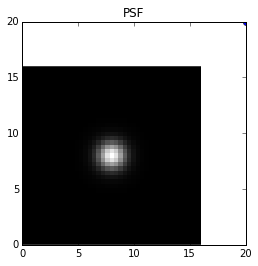

49.0 49.0
51.0 51.0
52 52
48 48


/Users/dreiss/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/dreiss/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:61: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


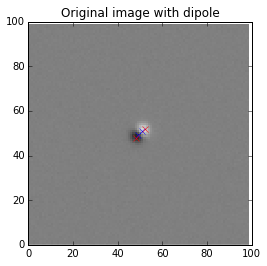

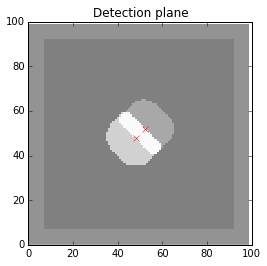

In [4]:
w, h = 100, 100 # size of image
xc, yc = 50, 50 # location of center of dipole
fracOffset = 0.7
display = True
psf, psfSum, exposure, s = createDipole(w, h, xc, yc, fracOffset=fracOffset)

In [5]:
## I think this is the meat of the code that runs the measurement. How do I get the complete set of (fitted) parameters out? 
## THat is the question!
## OK, figured it out, see below...
def measureDipole(s, exp):
    msConfig = ipDiffim.DipoleMeasurementConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("centroid_x", type=float)
    schema.addField("centroid_y", type=float)
    schema.addField("centroid_flag", type='Flag')
    task = ipDiffim.DipoleMeasurementTask(schema, config=msConfig)
    measCat = afwTable.SourceCatalog(schema)
    measCat.defineCentroid("centroid")
    source = measCat.addNew()
    source.set("centroid_x", xc)
    source.set("centroid_y", yc)
    source.setFootprint(s.getFootprint())

    print 'DIPOLE: ', source.get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    # Then run the default SFM task.  Results not checked
    task.run(measCat, exp)
    return measCat  ##[0] 

In [6]:
#print 'DIPOLE: ' + s.get(dipoleFlag)
sources = measureDipole(s, exposure) ## OK, this just returns the input coords but should set a dipole flag if it fits to a dipole
print 'DIPOLE: ', sources[0].get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
source = sources[0]
fp     = source.getFootprint()
peaks  = fp.getPeaks()
speaks = [(p.getPeakValue(), p) for p in peaks]
speaks.sort()
dpeaks = [speaks[0][1], speaks[-1][1]]
print dpeaks
##print source.schema
print source.getCentroid() ## This just returns the values set in the "source.set("centroid_x", xc), ..." lines... ??
print source.get("ip_diffim_NaiveDipoleCentroid_pos_x"), source.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
    source.get("ip_diffim_NaiveDipoleCentroid_neg_x"), source.get("ip_diffim_NaiveDipoleCentroid_neg_y")
print source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
    source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")

DIPOLE:  nan
DIPOLE:  1.0
[2: (48,48)  (48.000,48.000), 1: (52,52)  (52.000,52.000)]
(50, 50)
52.0150390625 52.0232177734 48.1874710083 48.1839958191
51.0193278824 51.0203238534 48.9781867049 48.9873981588


In [7]:
## provides (S/N, position, orientation) of measured dipoles
dpAnalysis = ipDiffim.DipoleAnalysis()
sn, centroid, orientation = dpAnalysis(source)
print sn, centroid, orientation

105.942879318 (49.999, 50.004) 0.787415 rad


In [8]:
## deblend a source as a dipole, and return a new source with deblended footprints.
dpDeblender = ipDiffim.DipoleDeblender()
deblendedSource = dpDeblender(source, exposure)
print deblendedSource.getCentroid()
print deblendedSource.get("ip_diffim_NaiveDipoleCentroid_pos_x"), deblendedSource.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
    deblendedSource.get("ip_diffim_NaiveDipoleCentroid_neg_x"), deblendedSource.get("ip_diffim_NaiveDipoleCentroid_neg_y")
print deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
    deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")

(50, 50)
52.0150390625 52.0232177734 48.1874710083 48.1839958191
51.0193278824 51.0203238534 48.9781867049 48.9873981588


In [9]:
# Recreate the simultaneous joint Psf fit in python
## This just fits for the flux of the dipole lobes, given a pair of input centroids.
def _makeModel(exposure, psf, fp, negCenter, posCenter):
    negPsf = psf.computeImage(negCenter).convertF()
    posPsf = psf.computeImage(posCenter).convertF()
    negPeak = psf.computePeak(negCenter)
    posPeak = psf.computePeak(posCenter)
    negPsf /= negPeak
    posPsf /= posPeak

    model    = afwImage.ImageF(fp.getBBox())
    negModel = afwImage.ImageF(fp.getBBox())
    posModel = afwImage.ImageF(fp.getBBox())

    # The center of the Psf should be at negCenter, posCenter
    negPsfBBox = negPsf.getBBox()
    posPsfBBox = posPsf.getBBox()
    modelBBox  = model.getBBox()

    # Portion of the negative Psf that overlaps the montage
    negOverlapBBox = afwGeom.Box2I(negPsfBBox)
    negOverlapBBox.clip(modelBBox)
    #self.assertFalse(negOverlapBBox.isEmpty())

    # Portion of the positivePsf that overlaps the montage
    posOverlapBBox = afwGeom.Box2I(posPsfBBox)
    posOverlapBBox.clip(modelBBox)
    #self.assertFalse(posOverlapBBox.isEmpty())

    negPsfSubim    = type(negPsf)(negPsf, negOverlapBBox)
    modelSubim     = type(model)(model, negOverlapBBox)
    negModelSubim  = type(negModel)(negModel, negOverlapBBox)
    modelSubim    += negPsfSubim  # just for debugging
    negModelSubim += negPsfSubim  # for fitting

    posPsfSubim    = type(posPsf)(posPsf, posOverlapBBox)
    modelSubim     = type(model)(model, posOverlapBBox)
    posModelSubim  = type(posModel)(posModel, posOverlapBBox)
    modelSubim    += posPsfSubim
    posModelSubim += posPsfSubim

    data = afwImage.ImageF(exposure.getMaskedImage().getImage(), fp.getBBox())
    var = afwImage.ImageF(exposure.getMaskedImage().getVariance(), fp.getBBox())
    matrixNorm = 1. / np.sqrt(np.median(var.getArray()))

    if display:
    #    ds9.mtv(model, frame=5, title="Unfitted model")
    #    ds9.mtv(data, frame=6, title="Data")
        fig = plt.figure()
        a = fig.add_subplot(1,2,1)
        plt.imshow(np.rot90(model.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Unfitted model (footprint?)')
        #plt.show()
        a = fig.add_subplot(1,2,2)
        plt.imshow(np.rot90(data.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Data')
        plt.show()

    posPsfSum = np.sum(posPsf.getArray())
    negPsfSum = np.sum(negPsf.getArray())

    M = np.array((np.ravel(negModel.getArray()), np.ravel(posModel.getArray()))).T.astype(np.float64)
    B = np.array((np.ravel(data.getArray()))).astype(np.float64)
    M *= matrixNorm
    B *= matrixNorm

    # Numpy solution
    fneg0, fpos0 = np.linalg.lstsq(M, B)[0]

    # Afw solution
    lsq = afwMath.LeastSquares.fromDesignMatrix(M, B, afwMath.LeastSquares.DIRECT_SVD)
    fneg, fpos = lsq.getSolution()

    # Should be exaxtly the same as each other
    #self.assertAlmostEqual(1e-2*fneg0,  1e-2*fneg)
    #self.assertAlmostEqual(1e-2*fpos0,  1e-2*fpos)

    # Recreate model
    fitted  = afwImage.ImageF(fp.getBBox())
    negFit  = type(negPsf)(negPsf, negOverlapBBox, afwImage.PARENT, True)
    negFit *= float(fneg)
    posFit  = type(posPsf)(posPsf, posOverlapBBox, afwImage.PARENT, True)
    posFit *= float(fpos)

    fitSubim  = type(fitted)(fitted, negOverlapBBox)
    fitSubim += negFit
    fitSubim  = type(fitted)(fitted, posOverlapBBox)
    fitSubim += posFit
    
    if display:
    #    ds9.mtv(fitted, frame=7, title="Fitted model")
        plt.imshow(np.rot90(fitted.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Fitted model')
        plt.show()

    fitted   -= data

    if display:
    #    ds9.mtv(fitted, frame=8, title="Residuals")
        plt.imshow(np.rot90(fitted.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Residuals')
        plt.show()

    fitted   *= fitted
    fitted   /= var

    if display:
    #    ds9.mtv(fitted, frame=9, title="Chi2")
        plt.imshow(np.rot90(fitted.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Chi2')
        plt.show()

    return fneg, negPsfSum, fpos, posPsfSum, fitted

(52, 52) (48, 48)


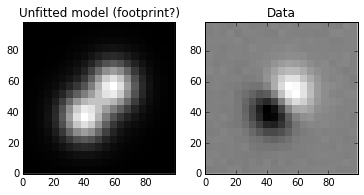

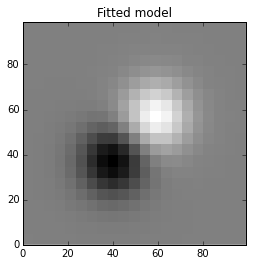

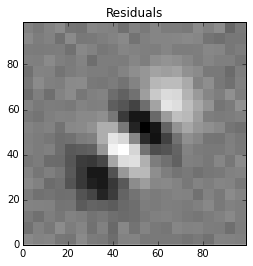

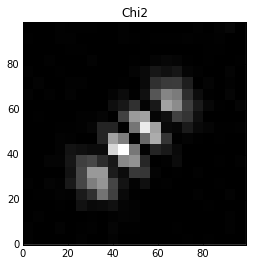

0.634971010708 0.633360909935


In [10]:
negCenter = afwGeom.Point2D(dpeaks[0].getFx(), dpeaks[0].getFy())
posCenter = afwGeom.Point2D(dpeaks[1].getFx(), dpeaks[1].getFy())
print posCenter, negCenter

display = True
fneg, negPsfSum, fpos, posPsfSum, residIm = _makeModel(exposure, psf, fp, negCenter, posCenter)

# Should be close to the same as the inputs; as fracOffset
# gets smaller this will be worse.
print -1e-2*fneg,  1e-2*fpos

## Looks like ACB's test code uses the integral value for the naive dipole fitted peak centroid...?

(51.019, 51.02) (48.978, 48.987)


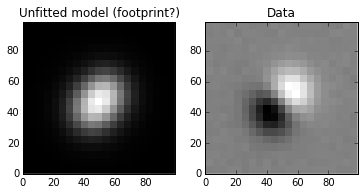

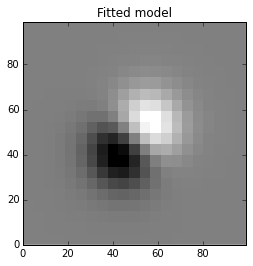

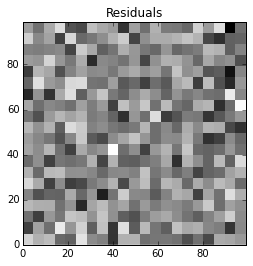

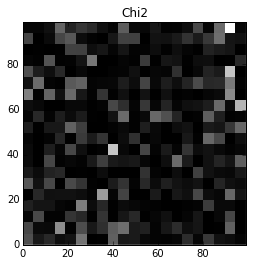

0.987660096814 0.985779020501


In [11]:
negCenter = afwGeom.Point2D(source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"))
posCenter = afwGeom.Point2D(source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"))
print posCenter, negCenter

display = True
fneg, negPsfSum, fpos, posPsfSum, residIm = _makeModel(exposure, psf, fp, negCenter, posCenter)

# Should be close to the same as the inputs
print -1e-2*fneg,  1e-2*fpos